# Figure 1

In [1]:
import numpy, pandas
import matplotlib
import matplotlib.pyplot as plt

## Figure 1a. Observed genetic variation in pncA

In [2]:
with open('./data/reference/NC_000962.3_pncA.fasta','r') as INPUT:
    INPUT.readline()
    pncA_sequence = INPUT.readline()

aminoacids = 'FFLLSSSSYY!!CC!WLLLLPPPPHHQQRRRRIIIMTTTTNNKKSSRRVVVVAAAADDEEGGGG'
bases = ['t', 'c', 'a', 'g']
all_codons = numpy.array([a+b+c for a in bases for b in bases for c in bases])
codon_to_amino_acid = dict(zip(all_codons, aminoacids))

In [3]:
index = 1

maximum_amino_acids = []
amino_acid_position = []

for codon in [pncA_sequence[i:i+3] for i in range(0,len(pncA_sequence),3)]:
    
    aminoacid = codon_to_amino_acid[codon]
    mutations = []

    for pos in [0, 1, 2]:
        for i in bases:
            if codon[pos] != i:
                new_codon = codon[:pos] + i + codon[pos+1:]
                new_aminoacid = codon_to_amino_acid[new_codon]

                if new_aminoacid != aminoacid and new_aminoacid not in mutations and new_aminoacid!="!":
                    mutations.append(new_aminoacid)

    # print(index, len(mutations))

    maximum_amino_acids.append(len(mutations))
    amino_acid_position.append(index)
    
    index+=1

max_aa = pandas.DataFrame(maximum_amino_acids, index=amino_acid_position, columns=['MAX'])

In [4]:
DATASET = pandas.read_csv('data/ds-traintest-phen.csv')
def find_position(row):
    return int(row.MUTATION[1:-1])

DATASET['POSITION'] = DATASET.apply(find_position, axis=1)
DATASET[:3]

,MUTATION,CONSISTENT_PHENOTYPE,POSITION
0,A102V,S,102
1,A134D,S,134
2,A134P,R,134


In [5]:
total = pandas.crosstab(DATASET.POSITION, DATASET.CONSISTENT_PHENOTYPE)
total['TOTAL'] = total.R + total.S
total['frac_R'] = total['R'] / total['TOTAL']
total = total.join(max_aa)
total

,R,S,TOTAL,frac_R,MAX
POSITION,,,,,
1,2,1,3,0.666667,6
2,0,1,1,0.000000,5
3,1,2,3,0.333333,6
4,4,1,5,0.800000,5
5,5,1,6,0.833333,7
...,...,...,...,...,...
181,1,1,2,0.500000,6
182,1,1,2,0.500000,5
183,1,2,3,0.333333,6


In [6]:
xs=[0.5]
ys=[0]
yt=[0]

prev_idx=0
for idx,row in total.iterrows():
    if idx-prev_idx!=1:
        print(idx, prev_idx)
    if idx==151:
        xs.append(149.5)
        xs.append(150.5)
        ys.append(0)
        ys.append(0)
        yt.append(0)
        yt.append(0)
    prev_idx=idx
    xs.append(idx-0.5)
    xs.append(idx+0.5)
    ys.append(row.TOTAL)
    ys.append(row.TOTAL)
    yt.append(row.MAX)
    yt.append(row.MAX)

151 149


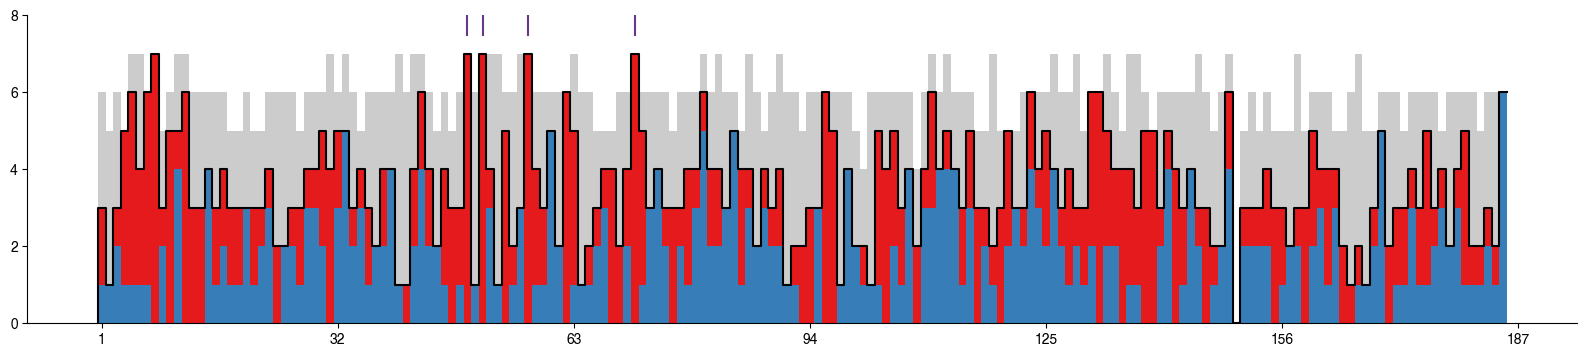

In [7]:
metal_binding_residues = [49,51,57,71]

active_site_residues = [8,13,19,68,96,133,134,137,138]

fig,axes=plt.subplots(1,1,figsize=(20,4))
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
axes.set_ylim([0,7])
axes.set_yticks(range(0,10,2))
axes.set_xticks(range(1,188,31))
axes.bar(total.index, total.MAX, width=1, color='#cccccc')
axes.bar(total.index, total.S, width=1, color='#377eb8')
axes.bar(total.index, total.R, bottom=total.S, width=1, color='#e41a1c')
axes.plot(xs,ys, color='black')

# annotate the metal binding sites
for i in metal_binding_residues:
    axes.plot((i,i),(7.5,8.5), color='#68378b')

# for i in active_site_residues:
#     axes.plot((i,i),(7.5,8.5), color='#e4bad7')

matplotlib.rcParams.update({'font.size': 24})
# axes.plot(xs,yt, color='black')
fig.savefig('pdf/fig-1_hist-codon.pdf',bbox_inches='tight',transparent=True)

In [8]:
'resid ' + ' '.join(str(i) for i in metal_binding_residues)

'resid 49 51 57 71'

In [9]:
'resid ' + ' '.join(str(i) for i in active_site_residues)

'resid 8 13 19 68 96 133 134 137 138'

## Figure 1b. Clinically-observed association between genetic variation in pncA and pyrazinamide resistance.

In [10]:
MUTATIONS_CORE = pandas.read_csv('data/source-data/cryptic1-mutations.csv')
MUTATIONS_CORE.set_index('UNIQUEID', inplace=True)

DST_CORE = pandas.read_csv('data/source-data/cryptic1-dst.csv')
DST_CORE.set_index('UNIQUEID', inplace=True)
MUTATIONS_CORE = MUTATIONS_CORE.join(DST_CORE[['PHENOTYPE']], how='left')
print("The CRyPTIC dataset contains %i samples and %i are resistant" % (len(DST_CORE), len(DST_CORE[DST_CORE.PHENOTYPE=='R'])))
print("%i samples have one or more mutations in pncA" % (len(MUTATIONS_CORE.index.unique())))


The CRyPTIC dataset contains 22842 samples and 3351 are resistant
6851 samples have one or more mutations in pncA


In [11]:
MUTATIONS_CORE.reset_index(inplace=True)
variants_per_sample = MUTATIONS_CORE[['UNIQUEID','POSITION']].groupby('UNIQUEID').count()
MUTATIONS_CORE.set_index('UNIQUEID', inplace=True)
variants_per_sample.POSITION.value_counts()

1    6622
2     228
3       1
Name: POSITION, dtype: int64

In [12]:
multi_variant_samples = variants_per_sample[variants_per_sample.POSITION>1].index
MUTATIONS_CORE.loc[multi_variant_samples].MUTATION.value_counts()[:10]

S65S         197
a-11g         18
H57D           7
398_indel      7
471_indel      5
M175V          5
L4S            4
H51Q           4
V9G            4
S74S           4
Name: MUTATION, dtype: int64

In [13]:
solos = variants_per_sample[variants_per_sample.POSITION==1].index
SOLO_MUTATIONS = MUTATIONS_CORE.loc[solos]

def define_nonsense(row):
    if row.MUTATION[-1] == '!':
        return True
    else:
        return False

def define_missense(row):
    if not row.IS_NONSENSE and row.IS_NONSYNONYMOUS:
        return True
    else:
        return False


SOLO_MUTATIONS['IS_NONSENSE'] = SOLO_MUTATIONS.apply(define_nonsense, axis=1)
SOLO_MUTATIONS['IS_MISSENSE'] = SOLO_MUTATIONS.apply(define_missense, axis=1)

n = len(SOLO_MUTATIONS)
n_indel = len(SOLO_MUTATIONS[SOLO_MUTATIONS.IS_INDEL])
n_syn = len(SOLO_MUTATIONS[SOLO_MUTATIONS.IS_SYNONYMOUS])
n_promoter = len(SOLO_MUTATIONS[(SOLO_MUTATIONS.IS_SNP) & (SOLO_MUTATIONS.IN_PROMOTER)])
n_missense = len(SOLO_MUTATIONS[(SOLO_MUTATIONS.IS_SNP) & (SOLO_MUTATIONS.IS_MISSENSE)])
n_nonsense = len(SOLO_MUTATIONS[(SOLO_MUTATIONS.IS_SNP) & (SOLO_MUTATIONS.IS_NONSENSE)])
print(n_promoter, n_syn, n_missense, n_nonsense, n_indel)
print("%.3f %.3f %.3f %.3f %.3f" % (n_promoter/n, n_syn/n, n_missense/n, n_nonsense/n, n_indel/n ))

167 3288 2691 75 401
0.025 0.497 0.406 0.011 0.061


In [14]:
n = len(SOLO_MUTATIONS)
n_indel_r = len(SOLO_MUTATIONS[SOLO_MUTATIONS.IS_INDEL & (SOLO_MUTATIONS.PHENOTYPE=='R')])
n_syn_r = len(SOLO_MUTATIONS[SOLO_MUTATIONS.IS_SYNONYMOUS & (SOLO_MUTATIONS.PHENOTYPE=='R')])
n_promoter_r = len(SOLO_MUTATIONS[(SOLO_MUTATIONS.IS_SNP) & (SOLO_MUTATIONS.IN_PROMOTER) & (SOLO_MUTATIONS.PHENOTYPE=='R')])
n_missense_r = len(SOLO_MUTATIONS[(SOLO_MUTATIONS.IS_SNP) & (SOLO_MUTATIONS.IS_MISSENSE) & (SOLO_MUTATIONS.PHENOTYPE=='R')])
n_nonsense_r = len(SOLO_MUTATIONS[(SOLO_MUTATIONS.IS_SNP) & (SOLO_MUTATIONS.IS_NONSENSE) & (SOLO_MUTATIONS.PHENOTYPE=='R')])
print(n_promoter_r, n_syn_r, n_missense_r, n_nonsense_r, n_indel_r)
print("%.3f %.3f %.3f %.3f %.3f" % (n_promoter_r/n_promoter, n_syn_r/n_syn, n_missense_r/n_missense, n_nonsense_r/n_nonsense, n_indel_r/n_indel ))

136 26 1970 68 343
0.814 0.008 0.732 0.907 0.855


In [15]:
df = SOLO_MUTATIONS[(SOLO_MUTATIONS.IS_SYNONYMOUS)]
pandas.crosstab(df.MUTATION, df.PHENOTYPE)

PHENOTYPE,R,S
MUTATION,,
A165A,0,2
A25A,0,1
A30A,0,1
A38A,0,17
A39A,0,1
A46A,2,0
D63D,1,0
E181E,0,1
G108G,0,1


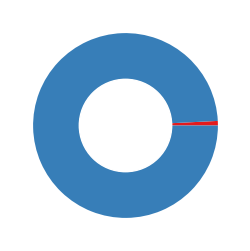

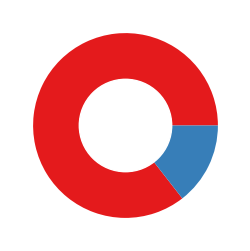

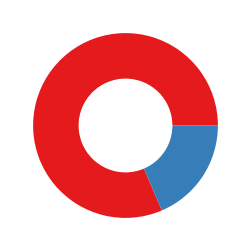

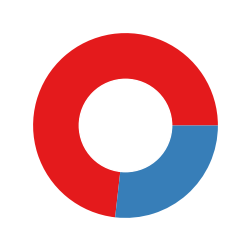

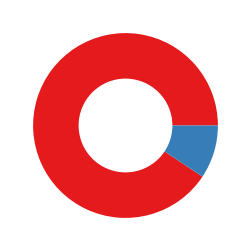

In [16]:
groups = {'syn': (n_syn_r,(n_syn-n_syn_r)),
          'indel': (n_indel_r,(n_indel-n_indel_r)),
          'promoter': (n_promoter_r,(n_promoter-n_promoter_r)),
          'missense': (n_missense_r,(n_missense-n_missense_r)),
          'nonsense': (n_nonsense_r,(n_nonsense-n_nonsense_r))
          }

colours = ['#e41a1c', '#377eb8']

size_of_groups=[n_syn_r,(n_syn-n_syn_r)]
size_of_groups=[n_missense_r,(n_missense-n_missense_r)]


for i in groups:

    size_of_groups = groups[i]    

    # Create a pieplot
    fig,axes=plt.subplots(1,1,figsize=(3,3))
    axes.pie(size_of_groups, colors=colours)

    # add a circle at the center to transform it in a donut chart
    my_circle=plt.Circle( (0,0), 0.5, color='white')
    fig.gca().add_artist(my_circle)
    fig.savefig('pdf/fig-donut-'+i+'.pdf',bbox_inches='tight',transparent=True)
    

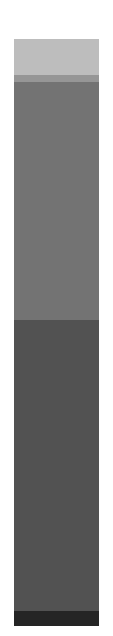

In [17]:
fig,axes=plt.subplots(1,1,figsize=(1.2,8))
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
axes.spines['bottom'].set_visible(False)
axes.spines['left'].set_visible(False)
axes.axis('off')
axes.bar(1, n_promoter, width=1, color='#252525')
axes.bar(1, n_syn, bottom=n_promoter, width=1, color='#525252')
axes.bar(1, n_missense, bottom=n_promoter+n_syn, width=1, color='#737373')
axes.bar(1, n_nonsense, bottom=n_promoter+n_syn+n_missense, width=1, color='#969696')
axes.bar(1, n_indel, bottom=n_promoter+n_syn+n_missense+n_nonsense, width=1, color='#bdbdbd')

fig.savefig('pdf/fig-1_hist-variation.pdf',bbox_inches='tight',transparent=True)